In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from category_encoders import TargetEncoder
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset 
df = pd.read_csv(r"C:\Users\David gathara marigi\Downloads\loan_data.csv")
print(df.head())

   UNIQUEID  DISBURSED_AMOUNT  ASSET_COST    LTV  BRANCH_ID  SUPPLIER_ID  \
0    643538             48349       65210  76.68          3        16092   
1    595627             55159       62972  88.93         72        16682   
2    586518             67882      113530  61.66          7        23091   
3    491581             55613       69807  85.95        103        20285   
4    614684             46249       67645  70.22         67        18129   

   MANUFACTURER_ID  CURRENT_PINCODE_ID DATE_OF_BIRTH EMPLOYMENT_TYPE  ...  \
0               51                  51    20-12-1981        Salaried  ...   
1               45                 475    01-01-1976   Self employed  ...   
2               51                5858    26-03-1992   Self employed  ...   
3               86                6995    01-01-1997   Self employed  ...   
4               45                1511    22-02-1980        Salaried  ...   

  SEC_SANCTIONED_AMOUNT  SEC_DISBURSED_AMOUNT  PRIMARY_INSTAL_AMT  \
0          

In [3]:
# Date handling
df['DATE_OF_BIRTH'] = pd.to_datetime(df['DATE_OF_BIRTH'], format='%d-%m-%Y')
df['DISBURSAL_DATE'] = pd.to_datetime(df['DISBURSAL_DATE'], format='%d-%m-%Y')
df['AGE_AT_DISBURSAL'] = (df['DISBURSAL_DATE'] - df['DATE_OF_BIRTH']).dt.days / 365.25

In [4]:
# Parse text to numerical
def parse_years_months(val):
    if pd.isna(val):
        return 0
    parts = val.split()
    years = int(parts[0].replace('yrs', ''))
    months = int(parts[1].replace('mon', ''))
    return years * 12 + months

In [5]:
df['AVERAGE_ACCT_AGE_MONTHS'] = df['AVERAGE_ACCT_AGE'].apply(parse_years_months)
df['CREDIT_HISTORY_LENGTH_MONTHS'] = df['CREDIT_HISTORY_LENGTH'].apply(parse_years_months)


In [6]:
#Handle missing values
df['EMPLOYMENT_TYPE'] = df['EMPLOYMENT_TYPE'].fillna('Unknown')
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [7]:
# Binary feature
df['HAS_BUREAU_HISTORY'] = (df['PERFORM_CNS_SCORE'] > 0).astype(int)

In [8]:
# --- Feature Engineering ---

df['PRI_SANCTION_DISBURSED_DIFF'] = df['PRI_SANCTIONED_AMOUNT'] - df['PRI_DISBURSED_AMOUNT']
df['SEC_SANCTION_DISBURSED_DIFF'] = df['SEC_SANCTIONED_AMOUNT'] - df['SEC_DISBURSED_AMOUNT']
df['PRI_OVERDUE_ACCTS_RATIO'] = df['PRI_OVERDUE_ACCTS'] / (df['PRI_NO_OF_ACCTS'] + 1e-5)
df['PRI_DEBT_BURDEN'] = df['PRI_CURRENT_BALANCE'] / (df['PRI_DISBURSED_AMOUNT'] + 1e-5)
df['RECENT_DELINQUENCY_RATE'] = df['DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'] / (df['NEW_ACCTS_IN_LAST_SIX_MONTHS'] + 1e-5)
df['HAS_OVERDUE_ACCTS'] = ((df['PRI_OVERDUE_ACCTS'] > 0) | (df['SEC_OVERDUE_ACCTS'] > 0)).astype(int)

In [9]:
# --- Encoding ---

encoder = TargetEncoder(cols=['BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID', 'EMPLOYEE_CODE_ID'])
df_encoded = encoder.fit_transform(df, df['LOAN_DEFAULT'])
employment_dummies = pd.get_dummies(df_encoded['EMPLOYMENT_TYPE'], prefix='EMPLOYMENT')
df_encoded = pd.concat([df_encoded, employment_dummies], axis=1)


In [10]:
# Feature list
features = [
    'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'AGE_AT_DISBURSAL',
    'PERFORM_CNS_SCORE', 'HAS_BUREAU_HISTORY', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
    'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT',
    'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
    'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
    'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
    'AVERAGE_ACCT_AGE_MONTHS', 'CREDIT_HISTORY_LENGTH_MONTHS', 'NO_OF_INQUIRIES',
    'PRI_SANCTION_DISBURSED_DIFF', 'SEC_SANCTION_DISBURSED_DIFF', 'PRI_OVERDUE_ACCTS_RATIO',
    'PRI_DEBT_BURDEN', 'RECENT_DELINQUENCY_RATE', 'HAS_OVERDUE_ACCTS',
    'BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID', 'EMPLOYEE_CODE_ID',
    'EMPLOYMENT_Salaried', 'EMPLOYMENT_Self employed', 'EMPLOYMENT_Unknown'
]

In [11]:
X = df_encoded[features]
y = df_encoded['LOAN_DEFAULT']

In [12]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# --- Handle Imbalance ---
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

In [14]:
# --- Scale Features ---
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [15]:
# Initialize XGBClassifier with correct parameters
xgb = XGBClassifier(random_state=42, eval_metric='auc', enable_categorical=False)  

# Define parameter search space
xgb_params = {'n_estimators': (100, 500), 'max_depth': (3, 10), 'learning_rate': (0.01, 0.3), 'subsample': (0.6, 1.0), 'colsample_bytree': (0.6, 1.0)}

# Initialize BayesSearchCV with correct settings
xgb_opt = BayesSearchCV(xgb, xgb_params, n_iter=20, cv=StratifiedKFold(5, shuffle=True, random_state=42),  scoring='roc_auc', random_state=42,
 n_jobs=-1  # Parallelize if possible
)

# Fit the model
xgb_opt.fit(X_train_res, y_train_res)
xgb_best = xgb_opt.best_estimator_

In [16]:

# LightGBM
lgb = LGBMClassifier(random_state=42)
lgb_params = {'n_estimators': (100, 500), 'num_leaves': (20, 100), 'learning_rate': (0.01, 0.3),
              'bagging_fraction': (0.6, 1.0), 'feature_fraction': (0.6, 1.0)}
lgb_opt = BayesSearchCV(lgb, lgb_params, n_iter=20, cv=StratifiedKFold(5), scoring='roc_auc', random_state=42)
lgb_opt.fit(X_train_res, y_train_res)
lgb_best = lgb_opt.best_estimator_

[LightGBM] [Warning] feature_fraction is set=0.89109029727093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89109029727093
[LightGBM] [Warning] bagging_fraction is set=0.7640415835413256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640415835413256
[LightGBM] [Warning] feature_fraction is set=0.89109029727093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89109029727093
[LightGBM] [Warning] bagging_fraction is set=0.7640415835413256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640415835413256
[LightGBM] [Info] Number of positive: 50543, number of negative: 50543
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8610
[LightGBM] [Info] Number of data points in the train set: 101086, number of

In [17]:
# Neural Network
def create_nn():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train_res.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

In [18]:
nn = create_nn()
nn.fit(X_train_res, y_train_res, epochs=20, batch_size=32, verbose=0)

In [19]:
# --- Stacking ---

# Generate base model predictions
xgb_pred_train = xgb_best.predict_proba(X_train_res)[:, 1]
lgb_pred_train = lgb_best.predict_proba(X_train_res)[:, 1]
nn_pred_train = nn.predict(X_train_res).flatten()

[LightGBM] [Warning] feature_fraction is set=0.7824878599374152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7824878599374152
[LightGBM] [Warning] bagging_fraction is set=0.7097307164685895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097307164685895
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [20]:

xgb_pred_test = xgb_best.predict_proba(X_test)[:, 1]
lgb_pred_test = lgb_best.predict_proba(X_test)[:, 1]
nn_pred_test = nn.predict(X_test).flatten()

[LightGBM] [Warning] feature_fraction is set=0.7824878599374152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7824878599374152
[LightGBM] [Warning] bagging_fraction is set=0.7097307164685895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097307164685895
833/833 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [21]:

# Stack predictions
stacked_train = np.column_stack((xgb_pred_train, lgb_pred_train, nn_pred_train))
stacked_test = np.column_stack((xgb_pred_test, lgb_pred_test, nn_pred_test))

In [22]:
# Meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(stacked_train, y_train_res)
final_pred_proba = meta_learner.predict_proba(stacked_test)[:, 1]
final_pred = (final_pred_proba >= 0.5).astype(int)

In [24]:
# --- Evaluation ---

from sklearn.metrics import auc


roc_auc = roc_auc_score(y_test, final_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, final_pred_proba)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, final_pred)

In [25]:
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"F1-Score: {f1:.4f}")

ROC-AUC: 0.8392
PR-AUC: 0.7113
F1-Score: 0.6669


  0%|          | 0/100 [00:00<?, ?it/s]

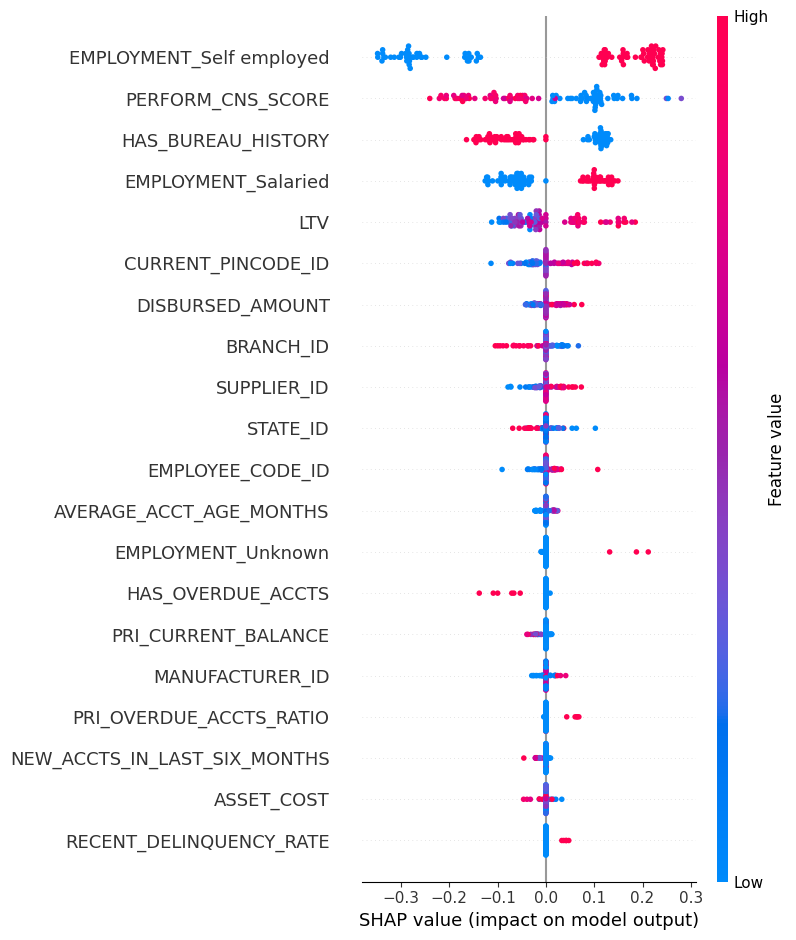

In [27]:
# --- Interpretability ---

explainer = shap.KernelExplainer(lambda x: xgb_best.predict_proba(x)[:, 1], X_test[:100])  # Subset for speed
shap_values = explainer.shap_values(X_test[:100])
shap.summary_plot(shap_values, X_test[:100], feature_names=features)